# Chladni Modes and Laplacian Spectrum

In [4]:
%matplotlib inline
#
from lrgsglib.core import *
#
move_to_rootf()
plt.style.use('ipynb/nb_plotsheet.mplstyle')
#
path_chladni = PATHDATA / 'chladni'
path_cluster_chladni = PATHDATA / 'cluster_data' / 'chladni'
path_plotchladni = PATHPLOT / 'chladni'

Current working directory: /home/opisthofulax/PhD/projects/complex-networks/lrgsglib


In [5]:
side = 48
geo = 'sqr'

In [25]:
l_tri_recon = Lattice2D(side, geo=geo, pflip=0)
l_tri_recon.flip_random_fract_edges()
l_tri_recon.compute_k_eigvV(with_routine='numpy')

In [52]:
gsN = l_tri_recon.N//8

In [53]:
isdy = IsingDynamics(l_tri_recon, T=0, ic=f'ground_state_{gsN}', runlang='C3', rndStr=True)
isdy.init_ising_dynamics()
l_tri_recon.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=80)
isdy.remove_run_c_files(remove_stderr=True)
l_tri_recon.remove_edgl_file()
s0_1 = isdy.s.reshape(*l_tri_recon.syshape)
isdy.init_ising_dynamics()
l_tri_recon.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=80)
isdy.remove_run_c_files(remove_stderr=True)
l_tri_recon.remove_edgl_file()
s0_2 = isdy.s.reshape(*l_tri_recon.syshape)

/tmp/ipykernel_281807/106407630.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(l_tri_recon.eigV[gsN].reshape(*l_tri_recon.syshape))), cmap='magma', vmin=-7)


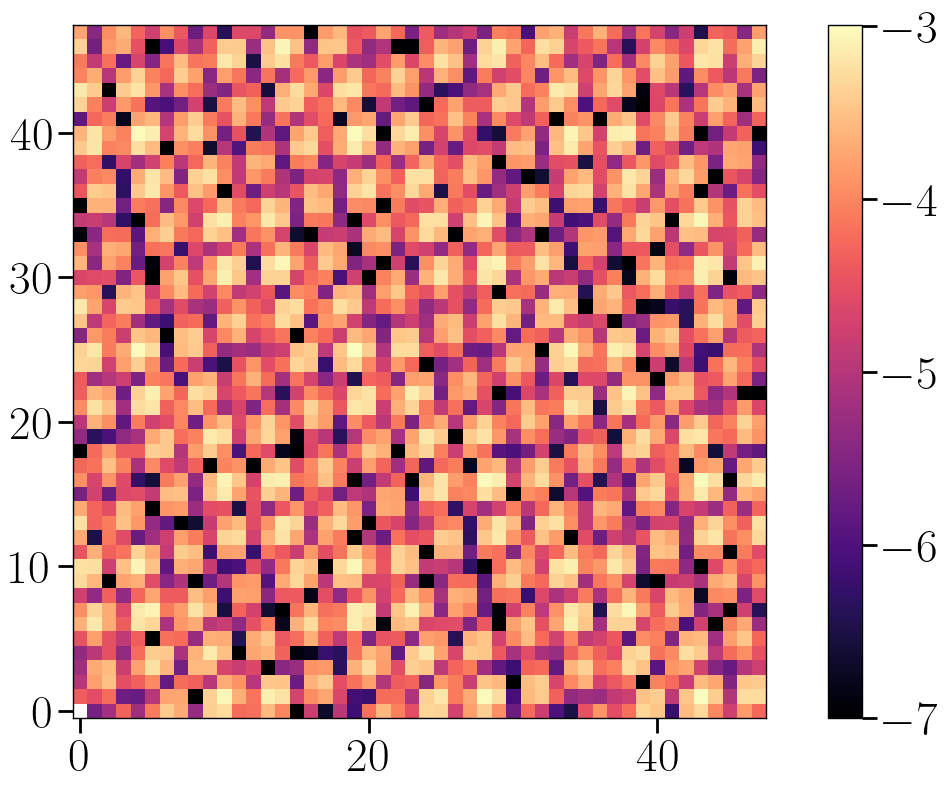

In [54]:
plt.imshow(np.log(np.abs(l_tri_recon.eigV[gsN].reshape(*l_tri_recon.syshape))), cmap='magma', vmin=-7)
plt.colorbar()

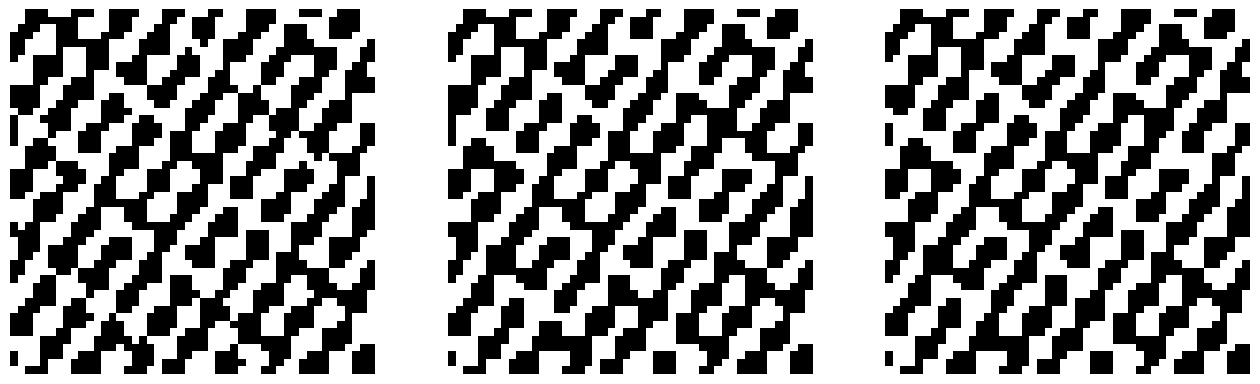

In [56]:
fig, ax = plt.subplots(ncols=3)
ax[0].imshow(l_tri_recon.get_eigV_bin_check(gsN).reshape(*l_tri_recon.syshape), cmap='binary')
ax[1].imshow(s0_1, cmap='binary')
ax[2].imshow(s0_2, cmap='binary')
for axx in ax:
    axx.axis('off')

## Energy plots

### Energy and magnetization

In [86]:
remove_files = False
geo = 'sqr'
side_list = [32, 64, 128]

In [87]:
l = {}
test_ene = {}
for side in side_list:
    fname = f'Lattice2D{geo}_wspect_{side}.pkl'
    pname = path_chladni / f'Lattice2D{geo}_wspect_{side}.pkl'
    if os.path.exists(pname):
        l[side] = pk.load(open(pname, 'rb'))
    else:
        l[side] = Lattice2D(side, geo=geo)
        l[side].compute_k_eigvV(with_routine='numpy')
        for _ in range(l[side].N):
            l[side].compute_rbim_energy_eigV(_)
        with open(pname, 'wb') as f:
            pk.dump(l[side], f)
    test_ene[side] = [l[side].get_rbim_energy_eigV(_)/(2*l[side].N) 
                      for _ in range(l[side].N)]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x736dd902d6d0>>
Traceback (most recent call last):
  File "/home/opisthofulax/anaconda3/envs/lrgsgenv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [6]:
ising_data = {'ene': {side: {} for side in side_list},
              'm': {side: {} for side in side_list},
              'sout': {side: {} for side in side_list}}
for side in side_list:
    initial_conditions = [1] + [l[side].N//8 * (_+1) - 1 for _ in range(8)]
    l[side].__init_paths__(path_data=path_chladni)
    l[side].__make_dirs__()
    for ic in initial_conditions:
        ene_file = l[side].path_ising / f'ene_p=0_T=0__gs{ic}.bin'
        
        if not os.path.exists(ene_file):
            print("file not found")
            # isdy = IsingDynamics(l[side], T=0., ic=f'ground_state_{ic}', 
            #                     runlang='C5', out_suffix=f'gs{ic}')
            # isdy.init_ising_dynamics()
            # l[side].export_edgel_bin(exName=isdy.id_string_isingdyn)
            # isdy.run(verbose=False, thrmSTEP=80)
            # isdy.remove_run_c_files(remove_stderr=True)
            # l[side].remove_edgl_file()
        ising_data['ene'][side][ic] = np.fromfile(ene_file, dtype=np.float64)
        m_file = l[side].path_ising / f'm_p=0_T=0__gs{ic}.bin'
        sout_file = l[side].path_ising / f'sout_p=0_T=0__gs{ic}.bin'
        ising_data['m'][side][ic] = np.fromfile(m_file, dtype=np.float64)
        ising_data['sout'][side][ic] = np.fromfile(sout_file, dtype=np.int8).reshape(-1, *l[side].syshape)

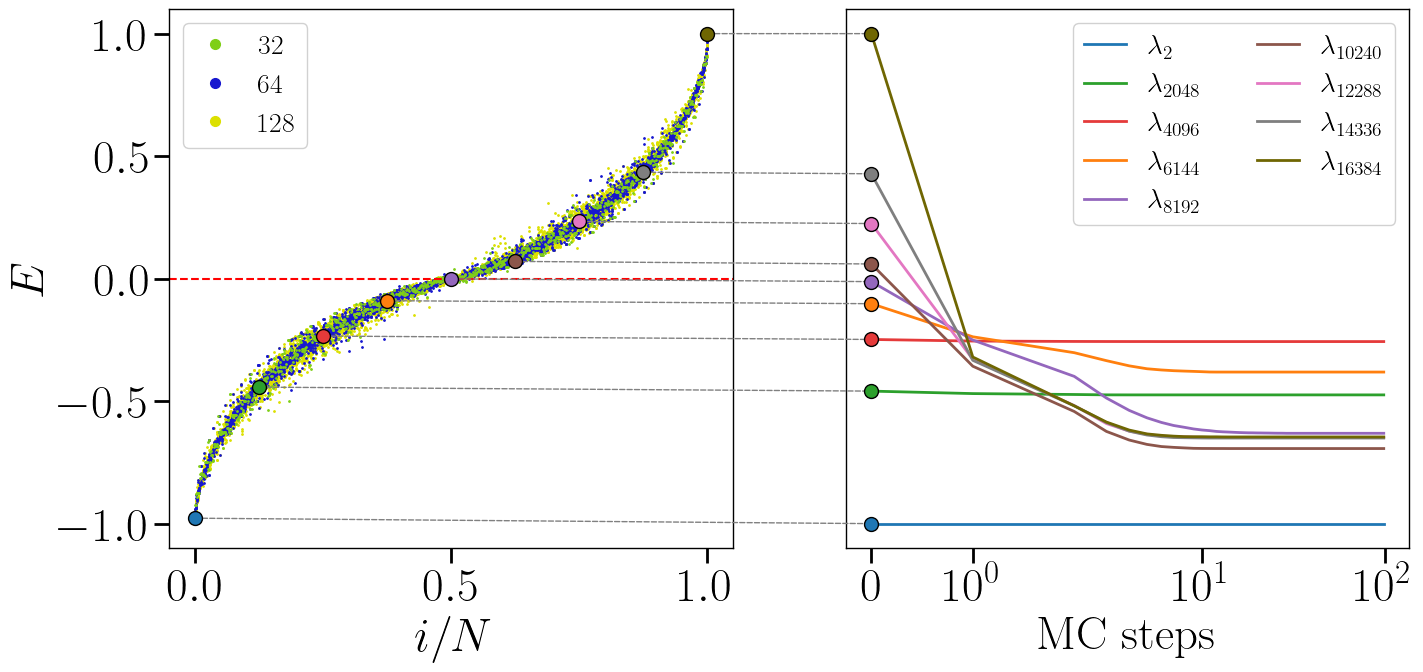

In [118]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 7))
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for _ in range(len(initial_conditions)+1):
    next(colors)
for side in side_list:
    ax[0].plot(np.linspace(0, 1, num=len(test_ene[side])), np.array(test_ene[side]), 'o', ms=1, label=f'{side}', zorder=1/side, color=next(colors))
y0 = [test_ene[side][ic] for ic in initial_conditions]
x0 = [ic/l[128].N for ic in initial_conditions]
ax[0].axhline(0, ls='--', color='r')
ax[0].set_ylabel(r'$E$')
ax[0].set_xlabel(r'$i/N$')
ax[0].legend(fontsize=20, markerscale=7.,)
x1 = [0 for _ in range(len(ising_data['ene'][128]))]
y1 = []
#
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for i, (egVnum, ene) in enumerate(ising_data['ene'][128].items()):
    color = next(colors)
    ax[1].plot(ene[:100]/4, '-', lw=2, label=fr'$\lambda_{{{egVnum+1}}}$', color=color)
    y1.append(ene[0]/4)
#
ax[1].set_yticks([])
ax[1].set_xscale('symlog')
ax[1].set_xlabel(r'MC steps')
ax[1].legend(fontsize=20, ncols=2)
#
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
for xi, yi, xf, yf in zip(x0, y0, x1, y1):
    color = next(colors)
    con = ConnectionPatch(xyA=(xi, yi), xyB=(xf, yf), coordsA="data", coordsB="data",
                        axesA=ax[0], axesB=ax[1], color="gray", ls='--', lw=1, zorder=1)
    fig.add_artist(con)
    disp0 = ax[0].transData.transform((xi, yi))  # data -> display coordinates
    fig_coord0 = fig.transFigure.inverted().transform(disp0)  # display -> figure coordinates
    
    marker0 = Line2D([fig_coord0[0]], [fig_coord0[1]],
                     marker='o', markersize=10,
                     markeredgecolor='k', markerfacecolor=color,  # adjust color as needed
                     linestyle='None', zorder=22)
    marker0.set_transform(fig.transFigure)
    fig.add_artist(marker0)
    fig.canvas.draw()
    disp1 = ax[1].transData.transform((xf, yf))
    fig_coord1 = fig.transFigure.inverted().transform(disp1)
    marker1 = Line2D([fig_coord1[0]], [fig_coord1[1]],
                    marker='o', markersize=10,
                    markeredgecolor='k', markerfacecolor=color,
                    linestyle='None', zorder=22)
    marker1.set_transform(fig.transFigure)
    fig.add_artist(marker1)
    # lineax, = ax[0].plot(xi, yi,'o',markersize=10, mec='k', zorder=22)
    # ax[1].plot(xf, yf,'o',markersize=10, color=lineax.get_color(), mec='k')
#
fig.savefig(path_plotchladni / f'rbim_energy_{geo}.pdf', bbox_inches='tight', 
            transparent=True)

In [119]:
lattice = l[128]
list_eigv = [1, lattice.N//64, lattice.N//4, lattice.N//2, 3*lattice.N//4]

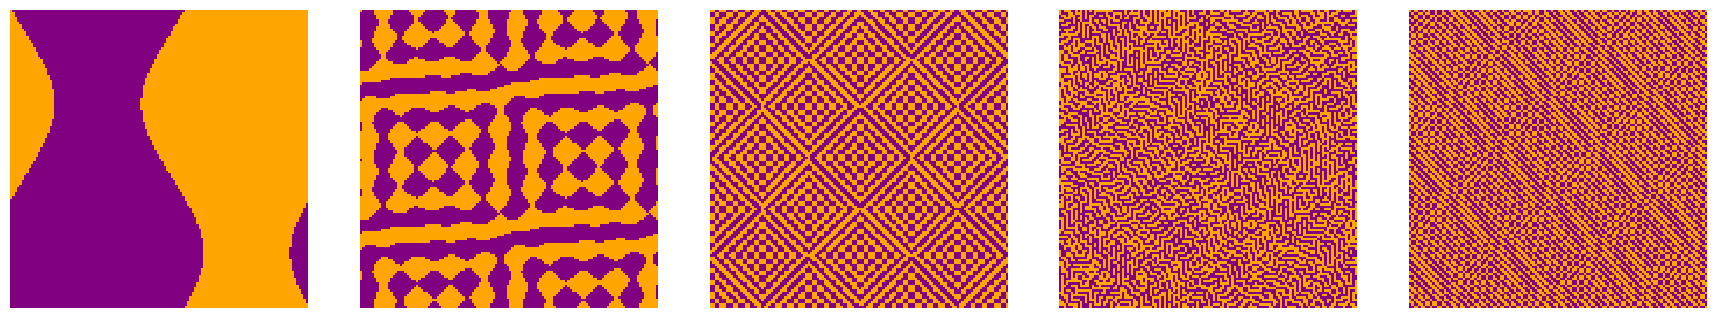

In [120]:
fig, ax = plt.subplots(1, 5, figsize=(18, 4))
cmap = ListedColormap(['purple', 'orange'])
for j,eigvn in enumerate(list_eigv):
    ax[j].imshow(lattice.get_eigV_bin_check(eigvn).reshape(*lattice.syshape), origin='lower', interpolation='none', cmap=cmap)
    ax[j].axis('off')
fig.tight_layout()
fig.savefig(path_plotchladni / f'rbim_eigv_{geo}.pdf', bbox_inches='tight', transparent=True)

### Cluster data (pointless)

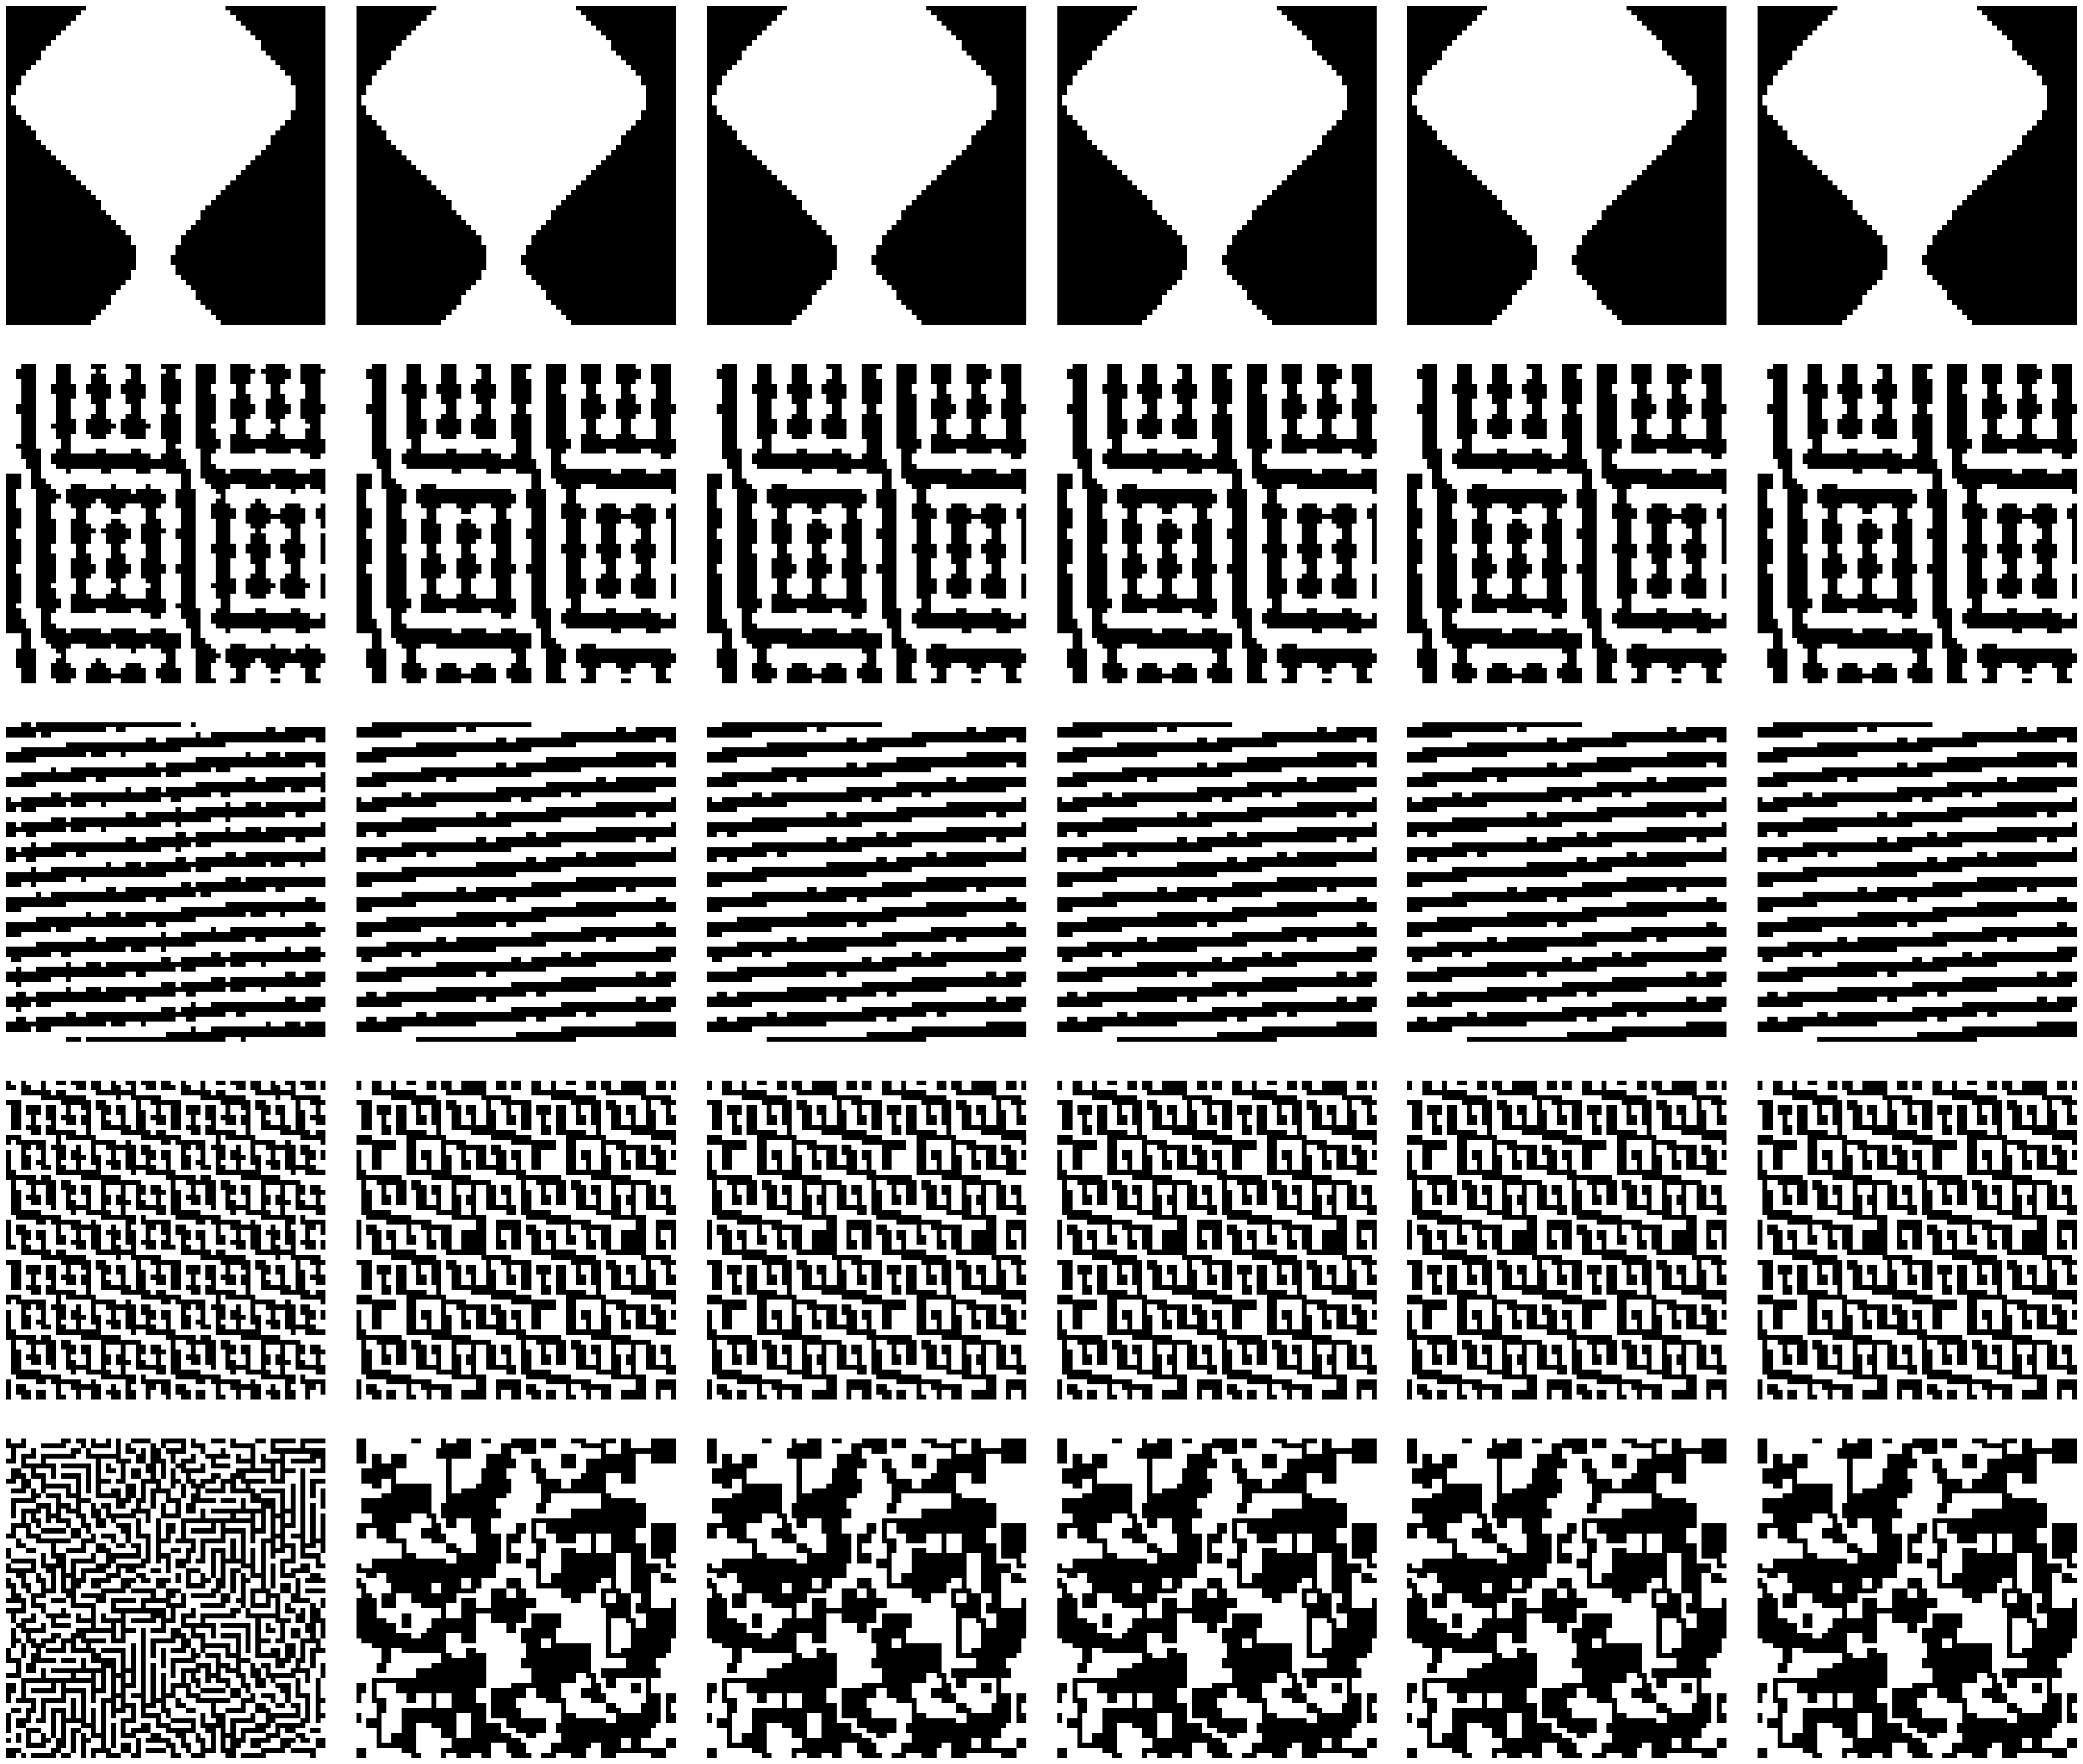

In [ ]:
chL2d = Lattice2D(64, path_data=path_cluster_chladni)

initial_conditions = [1, 256, 512, 1024, 2048, 4095]

# Random strings for each condition (replace these with actual values)
random_strings = ['1hEM7U6XlW', 'ZKXnhkvTGD', '1mHcs5hdJS', 'C1tg2VhIqW', 'FGsXt3Mz1e']

# Dictionaries for m_ and sout_ files
m_data = {}
sout_data = {}
ene_data = {}
# Loop over initial conditions and random strings
for egVnum, strrand in zip(initial_conditions, random_strings):
    # Load magnetization data
    m_file = chL2d.path_ising / f"m_p=0_T=0__{strrand}_gs{egVnum}rand.bin"
    if m_file.exists():
        m_data[egVnum] = np.fromfile(m_file, dtype=np.float64)
    
    # Load sout data if exists
    sout_file = chL2d.path_ising / f"sout_p=0_T=0__{strrand}_gs{egVnum}rand.bin"
    if sout_file.exists():
        sout_data[egVnum] = np.fromfile(sout_file, dtype=np.int8).reshape(-1, 64, 64)
    ene_file = chL2d.path_ising / f"ene_p=0_T=0__{strrand}_gs{egVnum}rand.bin"
    if ene_file.exists():
        ene_data[egVnum] = np.fromfile(ene_file, dtype=np.float64)

In [19]:
# Define the file pattern
file_pattern = "m*_gs2048rand.bin"
file_list = list(Path(chL2d.path_ising).glob(file_pattern))

# Read all matching files
data = {}
for file in file_list:
    data[file.name] = np.fromfile(file, dtype=np.float64)

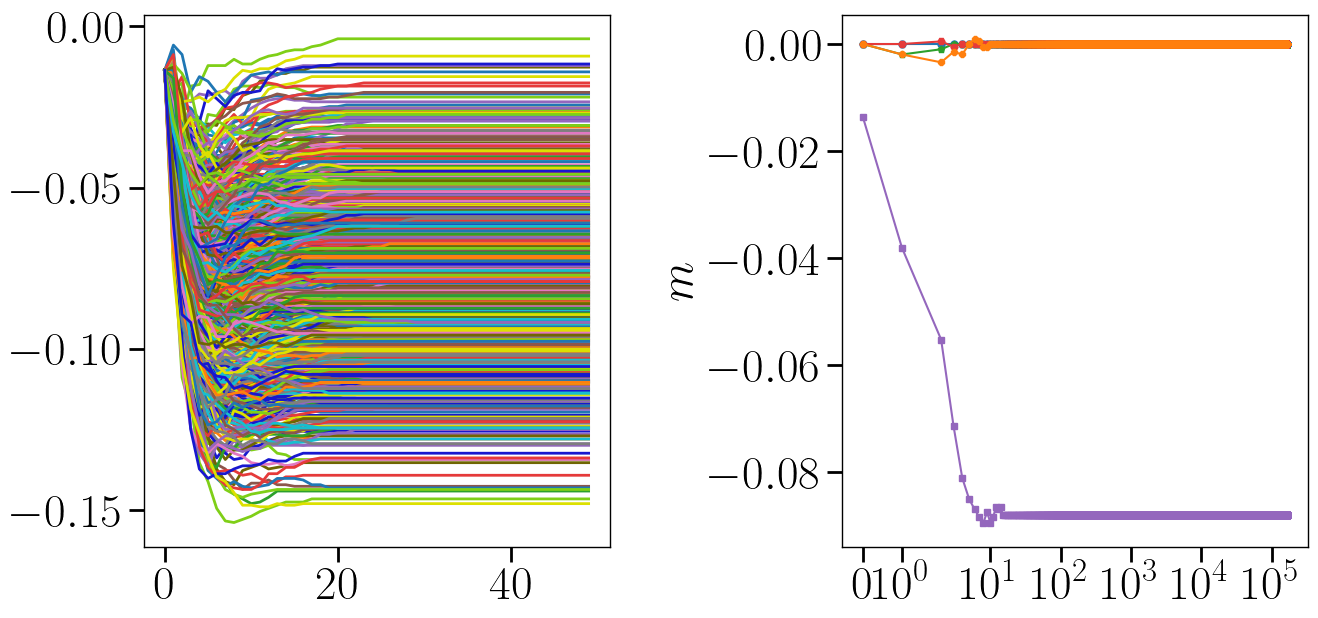

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(7*2, 7))

for i,ene in data.items():
    ax[0].plot(ene[:50], '-', lw=2)
for i, (egVnum, m) in enumerate(m_data.items()):
    ax[1].plot(m, label=f'{egVnum}')
ax[1].set_xscale('symlog')
ax[1].set_ylabel(r'$m$')
fig.tight_layout()

### Eigenstates Supplementary

In [11]:
list_eigv = np.linspace(1, 3*lattice.N//4, num=25, dtype=int)

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
cmap = ListedColormap(['purple', 'orange'])
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(lattice.get_eigV_bin_check(list_eigv[count]).reshape(*lattice.syshape), origin='lower', interpolation='none', cmap=cmap)
        ax[i,j].axis('off')
        ax[i, j].set_title(f'${list_eigv[count]/lattice.N:.2}$')
        count += 1
fig.tight_layout()

### Antiferro Reconstruction

In [63]:
T = 0.
geo = 'tri'
pflip = 1
remove_files = False
side = 64

In [64]:
l_tri_recon = Lattice2D(side, geo=geo, pflip=1)
l_tri_recon.flip_random_fract_edges()
l_tri_recon.compute_k_eigvV(with_routine='numpy')

In [76]:
isdy = IsingDynamics(l_tri_recon, T=T, ic='ground_state_0', runlang='C3', rndStr=True)
isdy.init_ising_dynamics()
l_tri_recon.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=80)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    l_tri_recon.remove_edgl_file()

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(l_tri_recon.get_eigV_bin_check(0).reshape(*l_tri_recon.syshape))
ax[1].imshow(isdy.s.reshape(*l_tri_recon.syshape))

In [80]:
# overlap = np.array([spin_overlap(isdy.s.reshape(*l.syshape),l.get_eigV_bin_check(i).reshape(*l.syshape)) for i in range(l.N)])
# sorted_args = np.argsort(overlap)[::-1]
matproj = isdy.s.reshape(*l_tri_recon.syshape)
basis = np.array([l_tri_recon.eigV[i].reshape(*l_tri_recon.syshape) for i in range(256)])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
recon = np.sign(reconstruct_from_projections(projections, basis))
ax[0].imshow(recon, origin='lower')
ax[1].imshow(isdy.s.reshape(*l_tri_recon.syshape), origin='lower')
p_overlap = spin_overlap(isdy.s.reshape(*l_tri_recon.syshape), recon)
print(p_overlap)

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(-l.get_eigV_bin_check(sorted_args[i]).reshape(*l.syshape), origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'{sorted_args[i]}')
ax[3].imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax[3].axis('off')
ax[4].imshow(np.sign(reconstruct_from_projections(projections, basis)), origin='lower')
ax[4].axis('off')

## SL

In [91]:
lsl = Lattice2D(64, pflip=0.2, geo='sqr')
lsl.flip_random_fract_edges()

In [92]:
lsl.compute_k_eigvV(with_routine='numpy')

In [93]:
isdy = IsingDynamics(lsl, T=0.5, ic='uniform', runlang='C3', rndStr=True)

In [94]:
isdy.init_ising_dynamics()
lsl.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=80)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    lsl.remove_edgl_file()

In [97]:
matproj = isdy.s.reshape(*lsl.syshape)
basis = np.array([lsl.eigV[i].reshape(*lsl.syshape) for i in range(256)])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
recon = np.sign(reconstruct_from_projections(projections, basis))
ax[0].imshow(recon, origin='lower')
ax[1].imshow(isdy.s.reshape(*l_tri_recon.syshape), origin='lower')
p_overlap = spin_overlap(isdy.s.reshape(*l_tri_recon.syshape), recon)
print(p_overlap)

In [104]:
ll = Lattice2D(64)
ll.compute_k_eigvV(with_routine='numpy')

In [ ]:
plt.imshow(np.abs(ll.eigV[0].reshape(*ll.syshape)), origin='lower')

## Trash

In [2]:
T = 0.0
geo = 'sqr'
pflip = 0
remove_files = False

In [3]:
l = Lattice2D(64, pflip=pflip, geo=geo)
l.flip_random_fract_edges()
l.compute_k_eigvV(with_routine='numpy')

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10, 3.5))
count = 0
for i in range(3):
    for j in range(5):
        ax[i, j].imshow(l.get_eigV_bin_check(count).reshape(*l.syshape), origin='lower')
        ax[i, j].axis('off')
        ax[i, j].set_title(f'{count}')
        count += 1

In [ ]:
test_ene = [l.get_rbim_energy_eigV(_)/(2*l.N) for _ in range(l.N)]
plt.plot(test_ene, 'o', ms=0.5)

In [140]:
isdy = IsingDynamics(l, T=T, ic='ground_state_0', runlang='C3', rndStr=True)
isdy.init_ising_dynamics()
l.export_edgel_bin(exName=isdy.id_string_isingdyn)
isdy.export_ising_clust()
isdy.run(verbose=False, thrmSTEP=200)
if remove_files:
    isdy.remove_run_c_files(remove_stderr=True)
    l.remove_edgl_file()

In [ ]:
4096*3000

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(l.get_eigV_bin_check(1023).reshape(*l.syshape))
ax[1].imshow(isdy.s.reshape(*l.syshape))

In [ ]:
np.exp(-1/0.1), 1/4096

In [95]:
ene = np.fromfile(l.isingpath /Path('ene_p=0_T=0_.bin'), dtype=np.float64)

In [ ]:
l.get_rbim_energy_eigV(2048)/(2*l.N)

In [ ]:
plt.plot(ene/(4))
# plt.yscale('symlog')
plt.xscale('symlog')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax.axis('off')

In [2]:
overlap = np.array([spin_overlap(isdy.s.reshape(*l.syshape),l.get_eigV_bin_check(i).reshape(*l.syshape)) for i in range(l.N)])
sorted_args = np.argsort(overlap)[::-1]
matproj = isdy.s.reshape(*l.syshape)
basis = np.array([l.eigV[i].reshape(*l.syshape) for i in sorted_args[:500]])
projections = np.array(matrix_projection(matproj, basis))

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(3):
    ax[i].imshow(-l.get_eigV_bin_check(sorted_args[i]).reshape(*l.syshape), origin='lower')
    ax[i].axis('off')
    ax[i].set_title(f'{sorted_args[i]}')
ax[3].imshow(isdy.s.reshape(*l.syshape), origin='lower')
ax[3].axis('off')
ax[4].imshow(np.sign(reconstruct_from_projections(projections, basis)), origin='lower')
ax[4].axis('off')

In [ ]:
spin_overlap(isdy.s.reshape(*l.syshape), np.sign(reconstruct_from_projections(projections, basis)))